# **IRIS 붓꽃 분류: Using DecisionTree**

## **1. 패키지 Import**

In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **2. 데이터 불러오기**

In [353]:
from sklearn import datasets

In [354]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data = iris.data, columns = iris.feature_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## **3. 학습/검증 데이터 분리 및 특징 선택**

In [355]:
from sklearn.model_selection._split import train_test_split

In [356]:
use_columns = iris_df.columns[[0,3]]
# use_columns = iris_df.columns[:]
use_columns

Index(['sepal length (cm)', 'petal width (cm)'], dtype='object')

In [357]:
X_train, X_test, y_train, y_test = train_test_split(
    iris_df[use_columns], # 학습에 사용할 원하는 특징 선택
    iris.target,
    test_size = 0.3,
    random_state = 4,
    stratify = iris.target # 분류 할 클래스의 비율 조정
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(105, 2) (45, 2) (105,) (45,)


## **5. DecisionTree 모델 객체 생성**

* 데이터 선택: X_train/X_test, X_train_ss/X_test_ss

In [358]:
X_train = X_train
X_test = X_test

In [359]:
from sklearn.tree import DecisionTreeClassifier

In [360]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

* **모델의 하이퍼 파라미터 불러오기**

In [361]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

* **하이퍼 파라미터 튜닝**

In [362]:
model = DecisionTreeClassifier(
    max_depth = 100,          # 5, 10 등
    # max_leaf_nodes = 100,     # 2~100 등
    min_samples_leaf = 1,  # 2~100 등
    min_samples_split = 2,  # 2~100 등
    criterion = 'entropy',     # 'gini', 'entropy' 등
)

In [363]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=100)

* **GridSearch를 통한 하이퍼파라미터 튜닝**

In [364]:
from sklearn.model_selection import GridSearchCV

In [365]:
param_grid = {
    "max_depth"      : [5, 10],
    "max_leaf_nodes"  : [2, 10, 50],
    "min_samples_split" : [2, 10, 50],
    "criterion" : ["gini", "entropy"]
}

grid_model = GridSearchCV(
    model, 
    param_grid=param_grid, 
    cv=2,   # K-fold
    refit=True)

In [366]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              max_depth=100),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'max_leaf_nodes': [2, 10, 50],
                         'min_samples_split': [2, 10, 50]})

In [367]:
# GridSearch 결과 중, 최적 하이퍼파라미터 학습 모델 객체 반환
print(grid_model.best_params_)
best_model = grid_model.best_estimator_ 

{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_split': 10}


## **6. 모델 평가하기**

* 모델 선택: model, best_model

In [368]:
# model = model
model = best_model

In [369]:
from sklearn.metrics import accuracy_score

In [370]:
y_pred = model.predict(X_test)
print(f'분류 정확도: {accuracy_score(y_test, y_pred)}')

분류 정확도: 0.9555555555555556


In [371]:
from sklearn.metrics import classification_report

In [372]:
print(classification_report(y_pred, y_test, target_names=['setosa','versicolor','virginica']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.93      0.93      0.93        15
   virginica       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



* Feature importance 확인

<AxesSubplot:>

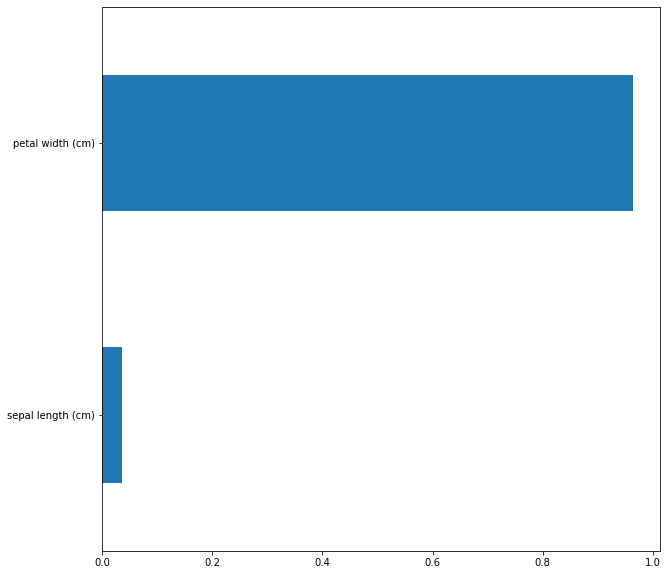

In [373]:
import pandas as pd
import matplotlib.pyplot as plt
# 특성 중요도 파악
# 특성 중요도 계산 후 X_test column으로 넣는다.
importance = pd.Series(model.feature_importances_, X_test.columns)
importance.sort_values().plot.barh()

## **7. 시각화**

> **주의**
> * 2차원으로 시각화 하기 때문에 특징을 2개를 사용하여 학습한 모델만 사용할 것

In [374]:
from matplotlib.colors import ListedColormap

C:\Users\fatal\anaconda3\envs\ailab\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


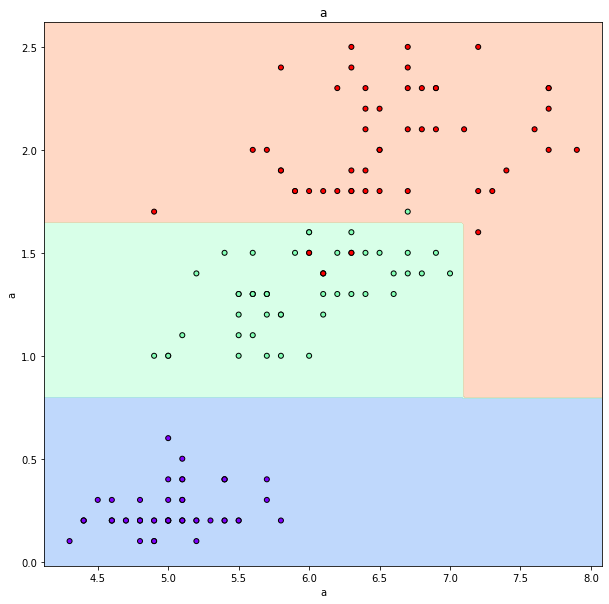

In [375]:
import numpy as np

plt.rcParams['figure.figsize'] = (10, 10)

def visualize_boundary(model, X, y, title, xlabel, ylabel):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k', zorder=3)
    ax.axis('tight')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5,cmap='rainbow',zorder=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
visualize_boundary(model, iris_df[use_columns].values, iris.target, 'a', 'a','a') 